<table><tr><td>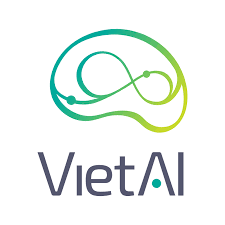</table></tr></td>

#Week01 - Assignment01: Retinal Disease Classification (Tensorflow Vesrion)
<hr>

###@Class: Advanced Computer Vision
###@Organize: VietAI
###@Description: We are proceeding to build a CNN model that allows to diagnosis  retinal diseases.

<b>Student Infomation:</b>
- Name: [your fullname]
- Email: [your email]
- Phone: [your phone]

<b>Describe your methods:</b>

Describes your method here....
<hr>

#Step 01: Setup Environment


##Check Colab GPU Information

In [ ]:
!nvidia-smi

Sun Sep  6 14:29:41 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

##Connect to Google Drive
You may be need store your own data later. Let Connect to Goole Drive for saving some necessary data.  

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


##Import and install all neccessary libraries


In [ ]:
#Authentication and download file from Google Drive
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import zipfile

import os
import sys
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import tensorflow as tf
import tensorflow.keras as keras

from fastprogress import master_bar, progress_bar

from PIL import Image

# Enable Eager Execution
#tf.enable_eager_execution() # No need use this, already enable with tf version >=2.0
tf.executing_eagerly() 

True

#Step 02: Reparing Retinal Disease Dataset

##Download retinal disease dataset

In [ ]:
#Restore all data from Google Drive to virtual Colab machine with File ID
zip_id = '1Nl4rhnP_22dJc_mbWvc4mv3e9Kmsv5JU' 
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

print ("Downloading vietai_advance_w1b_retinal_disease_classificaton.zip ...")
myzip = drive.CreateFile({'id': zip_id})
myzip.GetContentFile('vietai_advance_w1b_retinal_disease_classificaton.zip')

print ("Uncompressing vietai_advance_w1b_retinal_disease_classificaton.zip ...")
if not os.path.exists('retina_dataset'):
    os.makedirs('retina_dataset')
zip_ref = zipfile.ZipFile('vietai_advance_w1b_retinal_disease_classificaton.zip', 'r')
zip_ref.extractall('retina_dataset')
zip_ref.close()
os.remove("vietai_advance_w1b_retinal_disease_classificaton.zip")

os.listdir("retina_dataset")

Uncompressing vietai_advance_w1b_retinal_disease_classificaton.zip ...


['sample_submission.csv', 'test', 'train', 'train.csv', 'baseline_model']

## Read dataset

In [ ]:
data = pd.read_csv("retina_dataset/train.csv")
data.head()

,filename,opacity,diabetic retinopathy,glaucoma,macular edema,macular degeneration,retinal vascular occlusion,normal
0,c24a1b14d253.jpg,0,0,0,0,0,1,0
1,9ee905a41651.jpg,0,0,0,0,0,1,0
2,3f58d128caf6.jpg,0,0,1,0,0,0,0
3,4ce6599e7b20.jpg,1,0,0,0,1,0,0
4,0def470360e4.jpg,1,0,0,0,1,0,0


## Data analyzing

###Analyze distribution of 0 and 1 for each label

In [ ]:
for label in data.columns[1:]:
    print("Distribution of", label)
    print(data[label].value_counts())

Distribution of opacity
0    1902
1    1533
Name: opacity, dtype: int64
Distribution of diabetic retinopathy
0    2680
1     755
Name: diabetic retinopathy, dtype: int64
Distribution of glaucoma
0    2838
1     597
Name: glaucoma, dtype: int64
Distribution of macular edema
0    2919
1     516
Name: macular edema, dtype: int64
Distribution of macular degeneration
0    2861
1     574
Name: macular degeneration, dtype: int64
Distribution of retinal vascular occlusion
0    2995
1     440
Name: retinal vascular occlusion, dtype: int64
Distribution of normal
0    2910
1     525
Name: normal, dtype: int64


As can be observed, the number of label 0 is much more larger than label 1

### Analyze combination of classes

In [ ]:
LABELS = data.columns[1:]
def build_label(row):
    return ",".join([LABELS[idx] for idx, val in enumerate(row[1:]) if val == 1])
        
data.apply(lambda x: build_label(x), axis=1).value_counts()

In [ ]:
LABELS

Index(['opacity', 'diabetic retinopathy', 'glaucoma', 'macular edema',
       'macular degeneration', 'retinal vascular occlusion', 'normal'],
      dtype='object')

As we can see, **opacity**, **normal** and **glaucoma** are diseases that share largest proportions in label distribution. The other diseases or combinations just account for small pieces.

## Observations on the dataset
The dataset provided is extremely imbalanced. In this baseline model, by simply train the model the original dataset, we will easily get overfitting on the training set and the score on the test set is very low. With the proposed methods below, you will tweak the training process and improve the metric score on the test set:
- **Image Augmentation**: By augmenting images, we will have more data and make the training set become more regularize. [imgaug](https://github.com/aleju/imgaug) is a very strong augmentation library that you can use in this assignment
- **Data sampling**: the idea here is to make the distribution between classes in the dataset balance. There are 2 kinds: oversampling and undersampling
- **Adjust loss function**: the current loss function becomes very small after several epochs. By adding weights, we adjust the loss function to make it suitable for this imbalanced dataset. You can check the [BCEWithLogitsLoss](https://pytorch.org/docs/stable/nn.html#bcewithlogitsloss) and try applying it.
- **To simplify the baseline model, the dataset is splited randomly. However, to improve the model, cross-validation techniques can be applied here**

## Split the dataset
*For* the data provided, we will split the dataset to 80% for training and 20% for validation

In [ ]:
train_data, val_data = train_test_split(data, test_size=0.2, random_state=2020)

#Step 03: Build Baseline Model
In this notebook, we will use Pytorch library to implement and train ResNet50 as a baseline model. With initial weights from ImageNet, we will retrain all layers for this problem.

## Set some neccessary hyperparamaters

In [ ]:
IMAGE_SIZE = 224                              # Image size (224x224)
IMAGENET_MEAN = [0.485, 0.456, 0.406]         # Mean of ImageNet dataset (used for normalization)
IMAGENET_STD = [0.229, 0.224, 0.225]          # Std of ImageNet dataset (used for normalization)
BATCH_SIZE = 64                             
LEARNING_RATE = 0.001
LEARNING_RATE_SCHEDULE_FACTOR = 0.1           # Parameter used for reducing learning rate
LEARNING_RATE_SCHEDULE_PATIENCE = 5           # Parameter used for reducing learning rate
MAX_EPOCHS = 100                              # Maximum number of training epochs

## Implement Dataset loader
In Keras, you can use `ImageDataGenerator` to feed image to the model. However, the supported augmentation of `ImageDataGenerator` is not enough, we can add more from another library in this `preprocessing_image` below

In [ ]:
def preprocessing_image(image):
    """
    Preprocess image after resize and augment data with ImageDataGenerator
    
    Parameters
    ----------
    image: numpy tensor with rank 3
        image to preprocessing
    
    Returns
    -------
    numpy tensor with rank 3
    """
    # TODO: augment more here
    
    return image

Create data generator object

In [ ]:
train_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                             featurewise_center=True,
                                                             featurewise_std_normalization=True,
                                                             preprocessing_function=preprocessing_image)

`ImageDataGenerator` only accepts list of strings as label, we need to convert the label in the dataframe following that way

In [ ]:
def build_label_list(row):
    return [LABELS[idx] for idx, val in enumerate(row[1:]) if val == 1]
        
train_data["label"] = train_data.apply(lambda x: build_label_list(x), axis=1)
val_data["label"] = val_data.apply(lambda x: build_label_list(x), axis=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


Create training generator

In [ ]:
train_gen = train_datagen.flow_from_dataframe(dataframe=train_data, 
                                        directory="retina_dataset/train/train", 
                                        x_col="filename", 
                                        y_col="label",
                                        class_mode="categorical",
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE), 
                                        batch_size=BATCH_SIZE)

Found 2748 validated image filenames belonging to 7 classes.


We also need to create validation generator. Different from training generator, we don't shuffle the validation set

In [ ]:
val_gen = train_datagen.flow_from_dataframe(dataframe=val_data, 
                                        directory="retina_dataset/train/train", 
                                        x_col="filename", 
                                        y_col="label",
                                        class_mode="categorical",
                                        shuffle=False,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE), 
                                        batch_size=BATCH_SIZE)

Found 687 validated image filenames belonging to 7 classes.


## Define model
In the baseline, we use ResNet50 pretrained on ImageNet dataset. The classifier of model would be replaced with a new dense layer to make the output suit the problem.

In [ ]:
base_model = keras.applications.ResNet50(input_shape=(IMAGE_SIZE,IMAGE_SIZE,3),
                                    include_top=False,
                                    weights='imagenet')
base_model.trainable = True

model = keras.Sequential([
  base_model,
  keras.layers.GlobalAveragePooling2D(),
  keras.layers.Dense(len(LABELS), activation='sigmoid')
])

# Print out model summary
model.summary()

94773248/94765736 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 7)                 14343     
Total params: 23,602,055
Trainable params: 23,548,935
Non-trainable params: 53,120
_________________________________________________________________


We need to train about 23 millions parameters

#Step 04: Training Model

## Define F1-score
Keras recently removed the F1-score metric, we will implement it in the function below:

In [ ]:
import tensorflow.keras.backend as K

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

## Define callbacks
There are 2 callbacks we need to add to the training:
- Saving the best model on validation set
- Reduce learning rate during training

In [ ]:
mcp = keras.callbacks.ModelCheckpoint("resnet50.h5", monitor="val_f1", save_best_only=True, save_weights_only=True, verbose=1,mode='max')
rlr = keras.callbacks.ReduceLROnPlateau(monitor='val_f1', factor=LEARNING_RATE_SCHEDULE_FACTOR, mode='max', patience=LEARNING_RATE_SCHEDULE_PATIENCE, min_lr=1e-8, verbose=1)
callbacks = [mcp, rlr]

## Training
Fully training model


In [ ]:
device = '/gpu:0'

with tf.device(device):
    steps_per_epoch = train_gen.n // BATCH_SIZE
    validation_steps = val_gen.n // BATCH_SIZE
    
    model.compile(optimizer=keras.optimizers.Adam(lr=LEARNING_RATE), loss='binary_crossentropy', metrics=[f1])

    # Huấn luyện
    history = model.fit_generator(train_gen,
                                  steps_per_epoch=steps_per_epoch,
                                  epochs=MAX_EPOCHS,
                                  verbose=1,
                                  validation_data=val_gen,
                                  validation_steps=validation_steps,
                                  callbacks=callbacks)

Instructions for updating:
Please use Model.fit, which supports generators.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/100
42/42 [==============================] - ETA: 0s - loss: 0.3766 - f1: 0.5263
Epoch 00001: val_f1 improved from -inf to 0.12559, saving model to resnet50.h5
42/42 [==============================] - 31s 744ms/step - loss: 0.3766 - f1: 0.5263 - val_loss: 1236.3823 - val_f1: 0.1256
Epoch 2/100
42/42 [==============================] - ETA: 0s - loss: 0.2833 - f1: 0.6651
Epoch 00002: val_f1 did not improve from 0.12559
42/42 [==============================] - 29s 685ms/step - loss: 0.2833 - f1: 0.6651 - val_loss: 71.7005 - val_f1: 0.1256
Epoch 3/100
42/42 [==============================] - ETA: 0s - loss: 0.2324 - f1: 0.7360
Epoch 00003: val_f1 did not improve from 0.12559
42/42 [==============================] - 29s 691ms/step - loss: 0.2324 - f1: 0.7360 - val_loss: 13.6276 - val_f1: 0.1256
Epoch 4/100
42/42 [==============================] - ETA: 0s - loss: 0.1939 - f1: 0.7886
Epoch 00004: val_f1 improved from 0.12559 to 0.36005, saving model to resnet50.h5
42/42 [=============

#Step 05: Inference

##Read the test data

In [ ]:
test_df = pd.read_csv("retina_dataset/sample_submission.csv")
test_df.head()

,filename,predicted
0,e742d34a26d4.jpg,0 0
1,b193b6a6d68d.jpg,0 0
2,07e4191fa3a8.jpg,0 0
3,b1a911cb2e6c.jpg,0 0
4,d8ab9cda1b33.jpg,0 0


## Create test data generator

In [ ]:
test_gen = train_datagen.flow_from_dataframe(dataframe=test_df,
                                             directory="../input/test/test",
                                             x_col="filename",
                                             class_mode=None,
                                             shuffle=False,
                                             target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                             batch_size=BATCH_SIZE)

Found 350 validated image filenames.


## Load best model weights and switch to evaluation mode

In [ ]:
model.load_weights("resnet50.h5")

##Predict test images

In [ ]:
pred = model.predict_generator(test_gen)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


In [ ]:
labels = (train_gen.class_indices)
labels = dict((v,k) for k,v in labels.items())
labels
LABELS = list(LABELS)

def probs2label(probs):
    ''' Return real index following LABELS
    '''
    global LABELS, labels
    return " ".join([str(LABELS.index(labels[idx])) for idx, prob in enumerate(probs) if prob > 0.5])

In [ ]:
#test_df['predicted'] = np.apply_along_axis(probs2label, 1, pred)
for idx, row in test_df.iterrows():
    test_df.loc[idx]['predicted'] = probs2label(pred[idx])

##Write result to submission file

In [ ]:
test_df.to_csv("submission.csv", index=False)

In [ ]:
test_df.head()

,filename,predicted
0,e742d34a26d4.jpg,6
1,b193b6a6d68d.jpg,4 0
2,07e4191fa3a8.jpg,0
3,b1a911cb2e6c.jpg,0
4,d8ab9cda1b33.jpg,2


In [ ]:
pred

array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 1.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [1.7672777e-05, 2.8789043e-04, 9.9997354e-01, ..., 0.0000000e+00,
        9.9999058e-01, 1.2516975e-06],
       [4.6352148e-03, 3.6647916e-04, 3.2086360e-01, ..., 6.2286854e-06,
        9.9990308e-01, 1.9803643e-04],
       ...,
       [9.3174160e-01, 2.3356080e-04, 2.9428422e-02, ..., 9.3579292e-06,
        2.3050255e-01, 4.4465065e-05],
       [2.0586443e-01, 8.3863735e-05, 1.2040138e-05, ..., 1.8656254e-05,
        9.9385738e-01, 2.7793646e-04],
       [3.5405159e-05, 9.9999946e-01, 7.8678131e-06, ..., 5.9604645e-07,
        1.3281384e-07, 6.9934458e-06]], dtype=float32)

In [ ]:
train_gen.class_indices

{'diabetic retinopathy': 0,
 'glaucoma': 1,
 'macular degeneration': 2,
 'macular edema': 3,
 'normal': 4,
 'opacity': 5,
 'retinal vascular occlusion': 6}